In [18]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error as MSE

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
os.chdir('/content/drive/MyDrive/Python')

In [21]:
train = pd.read_csv("train.csv", sep=",")
test = pd.read_csv("test.csv", sep=",")
submission = pd.read_csv("sample_submit.csv", sep=",", index_col=0, header=None)

In [22]:
train.isnull().sum()

id                            0
accommodates                  0
amenities                     0
bathrooms                   147
bed_type                      0
bedrooms                     71
beds                         96
cancellation_policy           0
city                          0
cleaning_fee                  0
description                   0
first_review              11908
host_has_profile_pic        148
host_identity_verified      148
host_response_rate        13704
host_since                  148
instant_bookable              0
last_review               11880
latitude                      0
longitude                     0
name                          0
neighbourhood              5160
number_of_reviews             0
property_type                 0
review_scores_rating      12556
room_type                     0
thumbnail_url              6145
zipcode                     716
y                             0
dtype: int64

In [23]:
#log1p(numpyの関数)を適用、対数をとる
#train["y"] = np.log1p(train["y"])

In [24]:
#欠損値・外れ値の場合のデータの削除はtrainのみに行う
train = train.dropna(subset=['bathrooms', 'bedrooms', 'beds'])

In [25]:
train.describe()

,id,accommodates,bathrooms,bedrooms,beds,latitude,longitude,number_of_reviews,review_scores_rating,y
count,55323.000000,55323.000000,55323.000000,55323.000000,55323.000000,55323.000000,55323.000000,55323.000000,42828.000000,55323.000000
mean,27787.181588,3.157023,1.236800,1.265857,1.713248,38.451258,-92.343858,20.923450,94.088167,160.307341
std,16043.404061,2.154204,0.583499,0.850230,1.259037,3.081077,21.686759,37.941297,7.795329,168.266655
min,0.000000,1.000000,0.000000,0.000000,0.000000,33.338905,-122.511500,0.000000,20.000000,1.000000
25%,13892.500000,2.000000,1.000000,1.000000,1.000000,34.128248,-118.341932,1.000000,92.000000,74.000000
50%,27778.000000,2.000000,1.000000,1.000000,1.000000,40.663287,-76.995867,6.000000,96.000000,111.000000
75%,41681.500000,4.000000,1.000000,1.000000,2.000000,40.746292,-73.954703,23.000000,100.000000,185.000000
max,55582.000000,16.000000,8.000000,10.000000,18.000000,42.390437,-70.999166,605.000000,100.000000,1999.000000


In [26]:
mean_val = train['review_scores_rating'].mean()
train['review_scores_rating'] = train['review_scores_rating'].fillna(mean_val)
test['review_scores_rating'] = test['review_scores_rating'].fillna(mean_val)

<ipython-input-26-9b546b6ef013>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['review_scores_rating'] = train['review_scores_rating'].fillna(mean_val)


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 23487 (\N{CJK UNIFIED IDEOGRAPH-5BBF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 27850 (\N{CJK UNIFIED IDEOGRAPH-6CCA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20385 (\N{CJK UNIFIED IDEOGRAPH-4FA1}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26684 (\N{CJK UNIFIED IDEOGRAPH-683C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


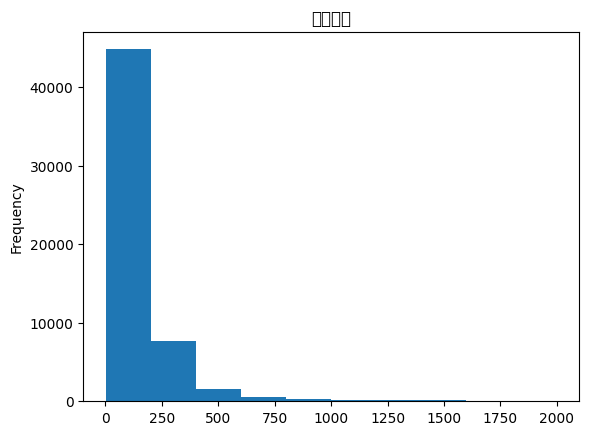

In [27]:
y = train['y']
y.plot.hist(title='宿泊価格')
plt.show()

In [28]:
print(y.value_counts().sort_index())

1.0        1
5.0        1
10.0      23
11.0       1
12.0       3
          ..
1938.0     1
1950.0     6
1980.0     1
1995.0     4
1999.0     3
Name: y, Length: 713, dtype: int64


In [29]:
before_rows = train.shape[0]
print(before_rows)

train = train[train['y'] >= 10]

after_rows = train.shape[0]
print(after_rows)

55323
55321


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12398 (\N{HIRAGANA LETTER NO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 38971 (\N{CJK UNIFIED IDEOGRAPH-983B}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


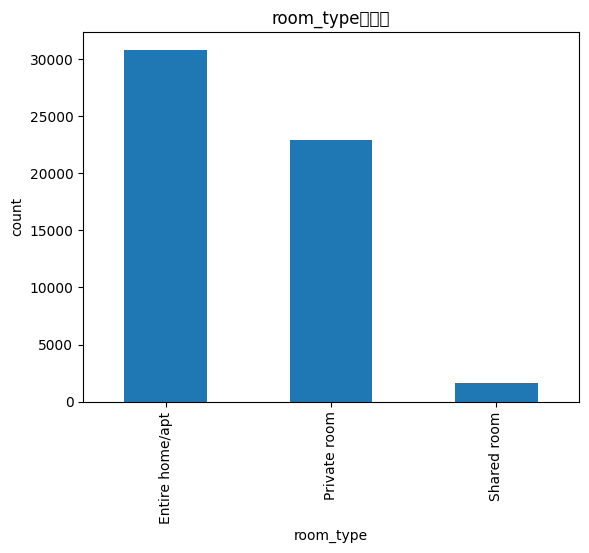

In [30]:
counts = train['room_type'].value_counts()
counts.plot.bar(title='room_typeの頻度')
plt.xlabel('room_type')
plt.ylabel('count')
plt.show()

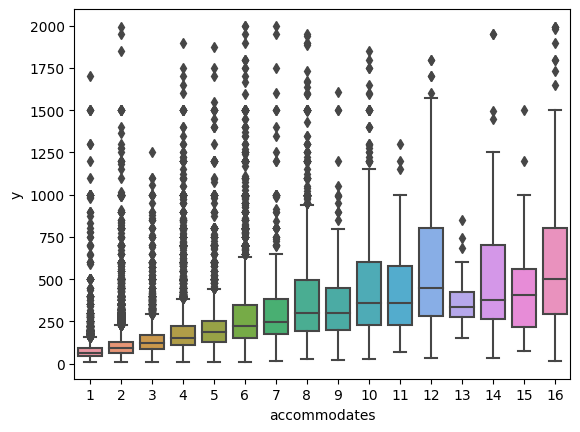

In [31]:
sns.boxplot(data=train, x='accommodates', y='y')
plt.show()

In [32]:
train.corr()

<ipython-input-32-0bc27f030cd9>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  train.corr()


,id,accommodates,bathrooms,bedrooms,beds,latitude,longitude,number_of_reviews,review_scores_rating,y
id,1.000000,0.005336,0.005254,0.002619,0.006015,-0.007467,-0.005732,0.004187,0.002155,-0.000605
accommodates,0.005336,1.000000,0.502631,0.708908,0.806720,-0.079466,-0.086381,0.042774,-0.016633,0.522398
bathrooms,0.005254,0.502631,1.000000,0.586309,0.524848,-0.135436,-0.132036,-0.040279,0.005506,0.456173
bedrooms,0.002619,0.708908,0.586309,1.000000,0.708311,-0.057357,-0.073983,-0.033710,0.008285,0.495749
beds,0.006015,0.806720,0.524848,0.708311,1.000000,-0.080455,-0.082604,0.031499,-0.025156,0.435510
latitude,-0.007467,-0.079466,-0.135436,-0.057357,-0.080455,1.000000,0.896483,-0.016547,-0.030824,-0.028791
longitude,-0.005732,-0.086381,-0.132036,-0.073983,-0.082604,0.896483,1.000000,-0.048897,-0.043787,-0.056141
number_of_reviews,0.004187,0.042774,-0.040279,-0.033710,0.031499,-0.016547,-0.048897,1.000000,0.011657,-0.068748
review_scores_rating,0.002155,-0.016633,0.005506,0.008285,-0.025156,-0.030824,-0.043787,0.011657,1.000000,0.045424
y,-0.000605,0.522398,0.456173,0.495749,0.435510,-0.028791,-0.056141,-0.068748,0.045424,1.000000


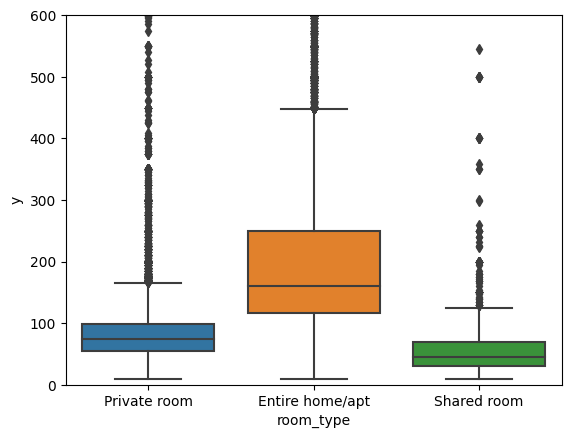

In [33]:
sns.boxplot(data=train, x='room_type', y='y')
plt.ylim(0,600)
plt.show()

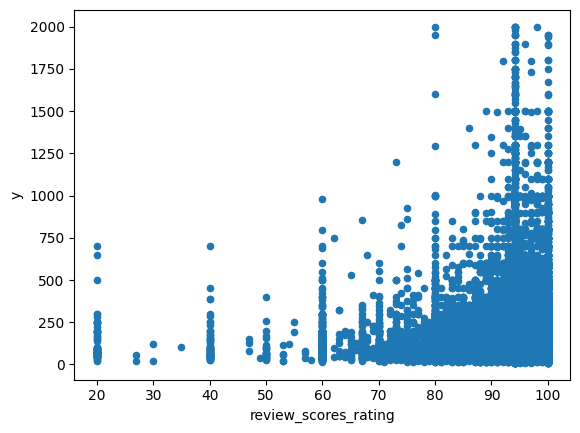

In [34]:
train.plot.scatter(x='review_scores_rating', y='y')
plt.show()

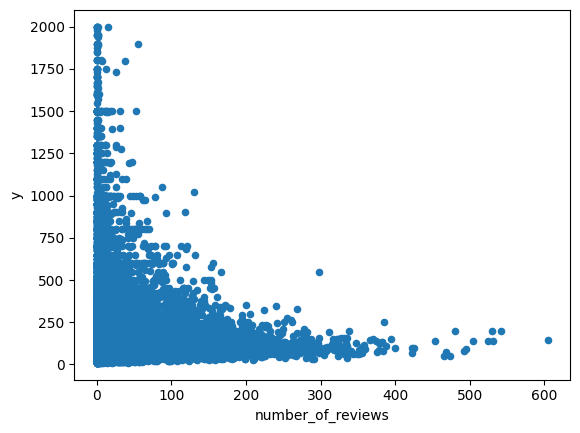

In [35]:
train.plot.scatter(x='number_of_reviews', y='y')
plt.show()

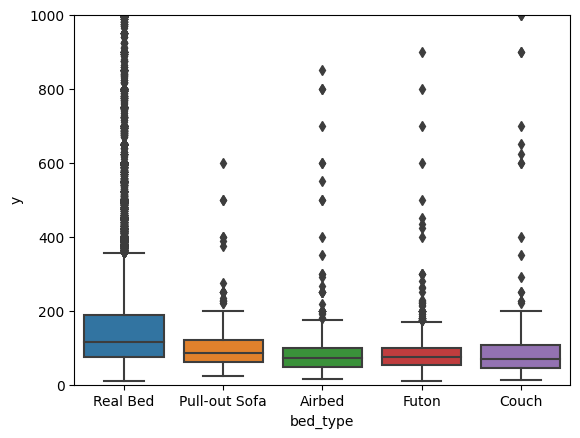

In [36]:
sns.boxplot(data=train, x='bed_type', y='y')
plt.ylim(0,1000)
plt.show()

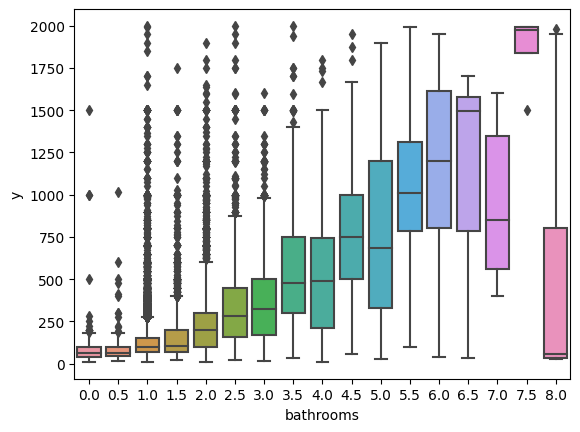

In [37]:
sns.boxplot(data=train, x='bathrooms', y='y')
plt.show()

In [38]:
train_tmp = train[(train['bathrooms']==0)&(train['y']>=1000)]
print(train_tmp)
print(train_tmp['name'])

          id  accommodates                                          amenities  \
1393    1393            10  {"Free parking on premises","Pets allowed","Fa...   
20726  20726             2             {"Pets allowed","Family/kid friendly"}   
54988  54988            16  {Internet,"Wireless Internet","Air conditionin...   

       bathrooms  bed_type  bedrooms  beds cancellation_policy     city  \
1393         0.0     Couch       0.0   1.0            flexible       LA   
20726        0.0  Real Bed       0.0   1.0            flexible       DC   
54988        0.0  Real Bed       0.0   1.0              strict  Chicago   

      cleaning_fee  ...   longitude                                      name  \
1393             f  ... -118.769788         Wedding Location Malibu Mountains   
20726            f  ...  -77.040188  Automobile Parking Place in Mt. Pleasant   
54988            t  ...  -87.690777      THE PAVILION + EVENTS + LOGAN SQUARE   

        neighbourhood number_of_reviews property_

In [39]:
def change_tf(x):
  if x == 't':
    return 1
  elif x == 'f':
    return 0

train['cleaning_fee'] = train['cleaning_fee'].apply(change_tf)
train['host_has_profile_pic'] = train['host_has_profile_pic'].apply(change_tf)
train['host_identity_verified'] = train['host_identity_verified'].apply(change_tf)
train['instant_bookable'] = train['instant_bookable'].apply(change_tf)

test['cleaning_fee'] = test['cleaning_fee'].apply(change_tf)
test['host_has_profile_pic'] = test['host_has_profile_pic'].apply(change_tf)
test['host_identity_verified'] = test['host_identity_verified'].apply(change_tf)
test['instant_bookable'] = test['instant_bookable'].apply(change_tf)

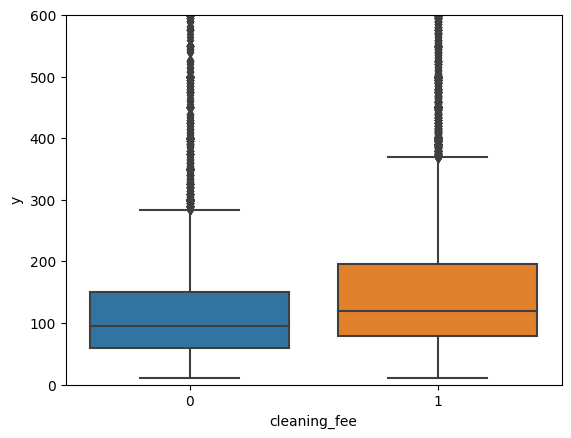

In [40]:
sns.boxplot(data=train, x='cleaning_fee', y='y')
plt.ylim(0,600)
plt.show()

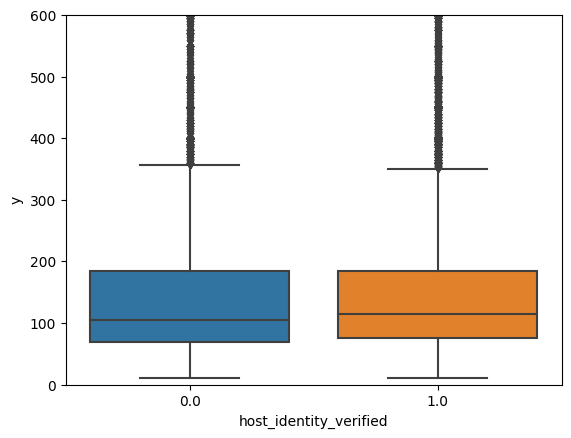

In [41]:
sns.boxplot(data=train, x='host_identity_verified', y='y')
plt.ylim(0,600)
plt.show()

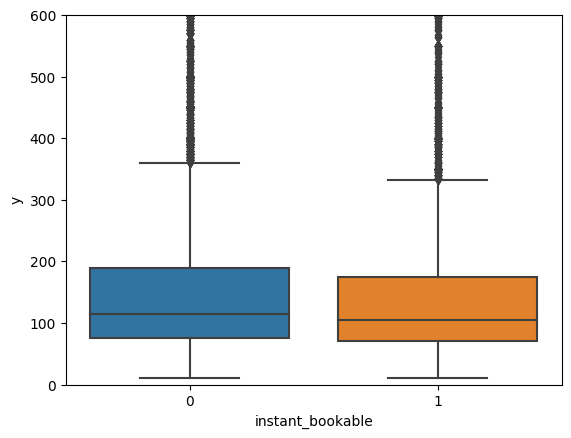

In [42]:
sns.boxplot(data=train, x='instant_bookable', y='y')
plt.ylim(0,600)
plt.show()

<Axes: xlabel='bathrooms', ylabel='y'>

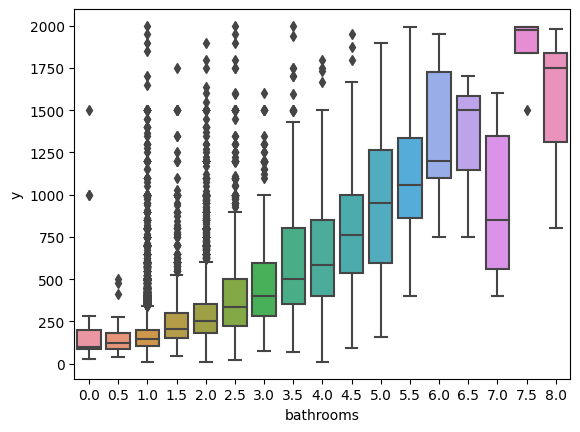

In [43]:
sns.boxplot(data=train[train['room_type'] == 'Entire home/apt'], x='bathrooms', y='y')

<Axes: xlabel='bathrooms', ylabel='y'>

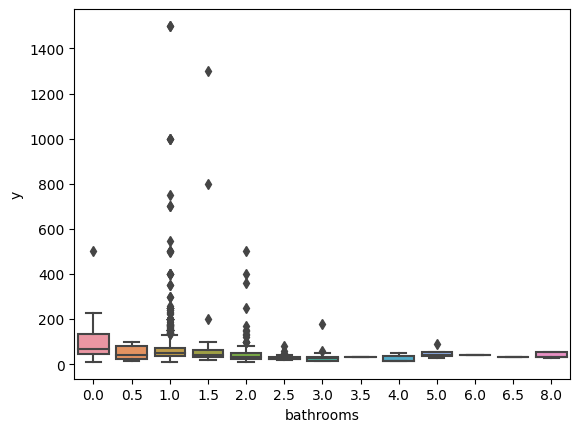

In [44]:
sns.boxplot(data=train[train['room_type'] == 'Shared room'], x='bathrooms', y='y')

<Axes: xlabel='beds', ylabel='y'>

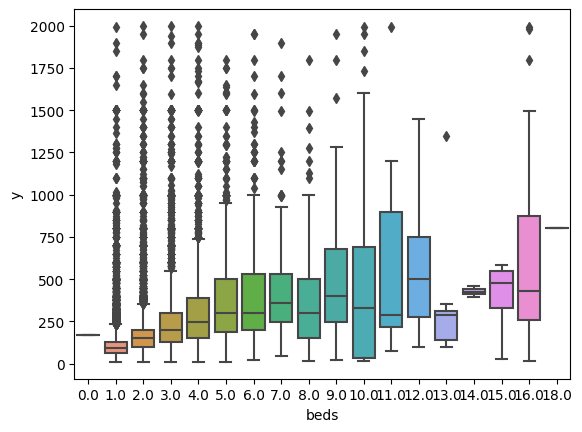

In [45]:
sns.boxplot(data=train, x='beds', y='y')

In [46]:
train.corr()

<ipython-input-46-0bc27f030cd9>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  train.corr()


,id,accommodates,bathrooms,bedrooms,beds,cleaning_fee,host_has_profile_pic,host_identity_verified,instant_bookable,latitude,longitude,number_of_reviews,review_scores_rating,y
id,1.000000,0.005336,0.005254,0.002619,0.006015,-0.006236,-0.002019,-0.007495,0.005278,-0.007467,-0.005732,0.004187,0.002155,-0.000605
accommodates,0.005336,1.000000,0.502631,0.708908,0.806720,0.181144,-0.007381,0.059402,0.054020,-0.079466,-0.086381,0.042774,-0.016633,0.522398
bathrooms,0.005254,0.502631,1.000000,0.586309,0.524848,0.052651,-0.007407,0.013567,0.002260,-0.135436,-0.132036,-0.040279,0.005506,0.456173
bedrooms,0.002619,0.708908,0.586309,1.000000,0.708311,0.106433,-0.004353,0.025651,-0.000757,-0.057357,-0.073983,-0.033710,0.008285,0.495749
beds,0.006015,0.806720,0.524848,0.708311,1.000000,0.131825,-0.001579,0.036651,0.053631,-0.080455,-0.082604,0.031499,-0.025156,0.435510
cleaning_fee,-0.006236,0.181144,0.052651,0.106433,0.131825,1.000000,0.019021,0.161878,0.008846,-0.061160,-0.068868,0.108056,0.025992,0.029352
host_has_profile_pic,-0.002019,-0.007381,-0.007407,-0.004353,-0.001579,0.019021,1.000000,0.074979,-0.010422,0.001681,0.000451,0.020726,0.004597,-0.021029
host_identity_verified,-0.007495,0.059402,0.013567,0.025651,0.036651,0.161878,0.074979,1.000000,-0.088498,-0.044221,-0.060453,0.160441,0.050990,-0.009902
instant_bookable,0.005278,0.054020,0.002260,-0.000757,0.053631,0.008846,-0.010422,-0.088498,1.000000,-0.010304,-0.004707,0.076696,-0.061048,-0.026340
latitude,-0.007467,-0.079466,-0.135436,-0.057357,-0.080455,-0.061160,0.001681,-0.044221,-0.010304,1.000000,0.896483,-0.016547,-0.030824,-0.028791


In [47]:
train.isnull().sum()

id                            0
accommodates                  0
amenities                     0
bathrooms                     0
bed_type                      0
bedrooms                      0
beds                          0
cancellation_policy           0
city                          0
cleaning_fee                  0
description                   0
first_review              11849
host_has_profile_pic        148
host_identity_verified      148
host_response_rate        13639
host_since                  148
instant_bookable              0
last_review               11821
latitude                      0
longitude                     0
name                          0
neighbourhood              5142
number_of_reviews             0
property_type                 0
review_scores_rating          0
room_type                     0
thumbnail_url              6100
zipcode                     705
y                             0
dtype: int64

In [48]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55321 entries, 0 to 55582
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      55321 non-null  int64  
 1   accommodates            55321 non-null  int64  
 2   amenities               55321 non-null  object 
 3   bathrooms               55321 non-null  float64
 4   bed_type                55321 non-null  object 
 5   bedrooms                55321 non-null  float64
 6   beds                    55321 non-null  float64
 7   cancellation_policy     55321 non-null  object 
 8   city                    55321 non-null  object 
 9   cleaning_fee            55321 non-null  int64  
 10  description             55321 non-null  object 
 11  first_review            43472 non-null  object 
 12  host_has_profile_pic    55173 non-null  float64
 13  host_identity_verified  55173 non-null  float64
 14  host_response_rate      41682 non-null

In [49]:
train.head()

,id,accommodates,amenities,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,cleaning_fee,...,longitude,name,neighbourhood,number_of_reviews,property_type,review_scores_rating,room_type,thumbnail_url,zipcode,y
0,0,6,"{TV,""Wireless Internet"",Kitchen,""Free parking ...",2.0,Real Bed,1.0,4.0,flexible,LA,1,...,-118.154761,The Penthouse,NaN,1,Apartment,60.0,Private room,NaN,90804,138.0
1,1,2,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",1.0,Real Bed,1.0,1.0,strict,DC,1,...,-76.978190,Guest Bedroom in Brookland,Brookland,9,House,100.0,Private room,https://a0.muscache.com/im/pictures/e4d8b51f-6...,20018,42.0
2,2,2,"{TV,Internet,""Wireless Internet"",Kitchen,""Indo...",2.0,Real Bed,1.0,1.0,strict,NYC,1,...,-73.926240,Clean Modern Room in Lux Apt 1 Block From J Train,Bushwick,27,Apartment,83.0,Private room,https://a0.muscache.com/im/pictures/5ffecc9b-d...,NaN,65.0
3,3,2,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",1.0,Real Bed,1.0,1.0,strict,SF,1,...,-122.411906,BEST views + reviews! 5/5 stars*****,Nob Hill,38,Apartment,95.0,Private room,NaN,94133,166.0
4,4,2,"{TV,Internet,""Wireless Internet"",""Air conditio...",1.0,Real Bed,1.0,1.0,strict,NYC,1,...,-73.974691,Charming 1-bedroom - UWS Manhattan,Upper West Side,5,Apartment,100.0,Entire home/apt,https://a0.muscache.com/im/pictures/92879730/5...,10024,165.0


In [50]:
#最後にあがく
train.amenities = train.amenities.str.count(',') +1
test.amenities = test.amenities.str.count(',') +1

In [51]:
train['super_strict_60'] = 0
train.loc[train['cancellation_policy'] == 'super_strict_60', 'super_strict_60'] = 1
test['super_strict_60'] = 0
test.loc[test['cancellation_policy'] == 'super_strict_60', 'super_strict_60'] = 1

In [52]:
train['description'] = train['description'].apply(lambda x: len(x))
test['description'] = test['description'].apply(lambda x: len(x))

In [53]:
train['real_bed'] = 0
train.loc[train['bed_type'] == 'Real Bed', 'real_bed'] = 1
test['real_bed'] = 0
test.loc[test['bed_type'] == 'Real Bed', 'read_bed'] = 1

<Axes: xlabel='real_bed', ylabel='y'>

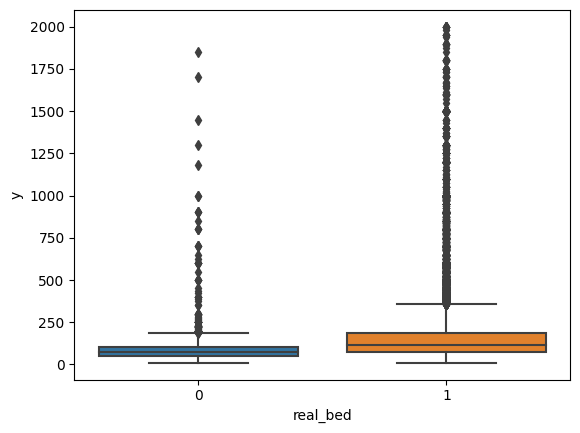

In [54]:
sns.boxplot(data=train, x='real_bed', y='y')

In [55]:
train['thumbnail_url'].fillna(0, inplace=True)
test['thumbnail_url'].fillna(0, inplace=True)

In [56]:
train['thumbnail'] = 0
train.loc[train['thumbnail_url'] != 0, 'thumbnail'] = 1
test['thumbnail'] = 0
test.loc[test['thumbnail_url'] != 0, 'thumbnail'] = 1

In [57]:
train['thumbnail'].value_counts()

1    49221
0     6100
Name: thumbnail, dtype: int64

In [58]:
train.head()

,id,accommodates,amenities,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,cleaning_fee,...,number_of_reviews,property_type,review_scores_rating,room_type,thumbnail_url,zipcode,y,super_strict_60,real_bed,thumbnail
0,0,6,7,2.0,Real Bed,1.0,4.0,flexible,LA,1,...,1,Apartment,60.0,Private room,0,90804,138.0,0,1,0
1,1,2,22,1.0,Real Bed,1.0,1.0,strict,DC,1,...,9,House,100.0,Private room,https://a0.muscache.com/im/pictures/e4d8b51f-6...,20018,42.0,0,1,1
2,2,2,29,2.0,Real Bed,1.0,1.0,strict,NYC,1,...,27,Apartment,83.0,Private room,https://a0.muscache.com/im/pictures/5ffecc9b-d...,NaN,65.0,0,1,1
3,3,2,18,1.0,Real Bed,1.0,1.0,strict,SF,1,...,38,Apartment,95.0,Private room,0,94133,166.0,0,1,0
4,4,2,18,1.0,Real Bed,1.0,1.0,strict,NYC,1,...,5,Apartment,100.0,Entire home/apt,https://a0.muscache.com/im/pictures/92879730/5...,10024,165.0,0,1,1


In [59]:
train.corr()

<ipython-input-59-0bc27f030cd9>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  train.corr()


,id,accommodates,amenities,bathrooms,bedrooms,beds,cleaning_fee,description,host_has_profile_pic,host_identity_verified,instant_bookable,latitude,longitude,number_of_reviews,review_scores_rating,y,super_strict_60,real_bed,thumbnail
id,1.000000,0.005336,-0.002096,0.005254,0.002619,0.006015,-0.006236,0.000376,-0.002019,-0.007495,0.005278,-0.007467,-0.005732,0.004187,0.002155,-0.000605,-0.002028,-0.002747,-0.001697
accommodates,0.005336,1.000000,0.266776,0.502631,0.708908,0.806720,0.181144,0.137154,-0.007381,0.059402,0.054020,-0.079466,-0.086381,0.042774,-0.016633,0.522398,0.034467,0.085413,-0.094242
amenities,-0.002096,0.266776,1.000000,0.161015,0.183956,0.234038,0.239107,0.317476,0.013462,0.142464,0.097112,-0.047967,-0.082402,0.182514,0.117673,0.134880,0.002691,0.034150,0.016776
bathrooms,0.005254,0.502631,0.161015,1.000000,0.586309,0.524848,0.052651,0.040934,-0.007407,0.013567,0.002260,-0.135436,-0.132036,-0.040279,0.005506,0.456173,0.049359,0.046864,-0.096528
bedrooms,0.002619,0.708908,0.183956,0.586309,1.000000,0.708311,0.106433,0.078456,-0.004353,0.025651,-0.000757,-0.057357,-0.073983,-0.033710,0.008285,0.495749,0.040979,0.065647,-0.089267
beds,0.006015,0.806720,0.234038,0.524848,0.708311,1.000000,0.131825,0.104579,-0.001579,0.036651,0.053631,-0.080455,-0.082604,0.031499,-0.025156,0.435510,0.028782,0.074891,-0.064861
cleaning_fee,-0.006236,0.181144,0.239107,0.052651,0.106433,0.131825,1.000000,0.272738,0.019021,0.161878,0.008846,-0.061160,-0.068868,0.108056,0.025992,0.029352,0.006530,0.032437,-0.021020
description,0.000376,0.137154,0.317476,0.040934,0.078456,0.104579,0.272738,1.000000,0.044374,0.218695,-0.022349,0.016525,-0.004367,0.266575,0.074184,0.001184,0.011483,-0.007051,0.006521
host_has_profile_pic,-0.002019,-0.007381,0.013462,-0.007407,-0.004353,-0.001579,0.019021,0.044374,1.000000,0.074979,-0.010422,0.001681,0.000451,0.020726,0.004597,-0.021029,0.000848,-0.009477,0.000482
host_identity_verified,-0.007495,0.059402,0.142464,0.013567,0.025651,0.036651,0.161878,0.218695,0.074979,1.000000,-0.088498,-0.044221,-0.060453,0.160441,0.050990,-0.009902,0.000650,0.000644,-0.025939


In [60]:
select_columns = ['room_type', 'accommodates', 'bed_type', 'bathrooms', 'cleaning_fee', 'beds', 'latitude', 'longitude', 'number_of_reviews', 'review_scores_rating', 'amenities', 'instant_bookable', 'description', 'real_bed', 'thumbnail']

train_entire = train[train['room_type'] == 'Entire home/apt']
train_private = train[train['room_type'] == 'Private room']
train_share = train[train['room_type'] == 'Shared room']
dummy_train_entire = pd.get_dummies(train_entire[select_columns], drop_first=True)
dummy_train_private = pd.get_dummies(train_private[select_columns], drop_first=True)
dummy_train_share = pd.get_dummies(train_share[select_columns], drop_first=True)

# データの分割
X_train_e, X_validation_e, y_train_e, y_validation_e = train_test_split(dummy_train_entire, train_entire['y'], random_state = 1234)
X_train_p, X_validation_p, y_train_p, y_validation_p = train_test_split(dummy_train_private, train_private['y'], random_state = 1234)
X_train_s, X_validation_s, y_train_s, y_validation_s = train_test_split(dummy_train_share, train_share['y'], random_state = 1234)

# entire
# モデルの準備
model_e = RandomForestRegressor(random_state=0, max_depth=30)
# モデルの学習
model_e.fit(X_train_e, y_train_e)
# 訓練データの予測
pred_e_train = model_e.predict(X_train_e)
# テストデータの予測
pred_e_validation = model_e.predict(X_validation_e)

# private
# モデルの準備
model_p = RandomForestRegressor(random_state=0, max_depth=30)
# モデルの学習
model_p.fit(X_train_p, y_train_p)
# 訓練データの予測
pred_p_train = model_p.predict(X_train_p)
# テストデータの予測
pred_p_validation = model_p.predict(X_validation_p)

# share
# モデルの準備
model_s = RandomForestRegressor(random_state=0, max_depth=30)
# モデルの学習
model_s.fit(X_train_s, y_train_s)
# 訓練データの予測
pred_s_train = model_s.predict(X_train_s)
# テストデータの予測
pred_s_validation = model_s.predict(X_validation_s)

In [61]:
'''
# パラメータの準備
parameters = {'max_depth':[2,3,4,5,6,7,8,9,10]}

# グリッドサーチの設定
gcv = GridSearchCV(model_e, parameters, cv=5, scoring='rmse', return_train_score=True)
gcv.fit(X_train_e, y_train_e)
'''

"\n# パラメータの準備\nparameters = {'max_depth':[2,3,4,5,6,7,8,9,10]}\n\n# グリッドサーチの設定\ngcv = GridSearchCV(model_e, parameters, cv=5, scoring='rmse', return_train_score=True)\ngcv.fit(X_train_e, y_train_e)\n"

In [62]:
import numpy as np
from sklearn.metrics import mean_squared_error as MSE

# pred_e_train, pred_p_train, pred_s_trainを1つの配列にして、pred_trainに代入してください。
pred_train = np.concatenate([pred_e_train, pred_p_train, pred_s_train])
# 実際の値であるy_train_e,y_train_p,y_train_sを1つの配列にして、answer_trainに代入してください。
answer_train = np.concatenate([y_train_e, y_train_p, y_train_s])
# pred_train,answer_trainから全訓練データの予測値のRMSEを求め、rmse_trainに代入してください。
rmse_train = np.sqrt(MSE(answer_train, pred_train))

# 同様に全テストデータの予測値のRMSEを求め、rmse_validationに代入してください。
pred_validation = np.concatenate([pred_e_validation, pred_p_validation, pred_s_validation])
answer_validation = np.concatenate([y_validation_e, y_validation_p, y_validation_s])
rmse_validation = np.sqrt(MSE(answer_validation, pred_validation))

print(rmse_train)
print(rmse_validation)

42.99390437419848
112.64173894210036


In [63]:
#テストデータの予測を行う

In [64]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18528 entries, 0 to 18527
Data columns (total 32 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      18528 non-null  int64  
 1   accommodates            18528 non-null  int64  
 2   amenities               18528 non-null  int64  
 3   bathrooms               18475 non-null  float64
 4   bed_type                18528 non-null  object 
 5   bedrooms                18508 non-null  float64
 6   beds                    18493 non-null  float64
 7   cancellation_policy     18528 non-null  object 
 8   city                    18528 non-null  object 
 9   cleaning_fee            18528 non-null  int64  
 10  description             18528 non-null  int64  
 11  first_review            14572 non-null  object 
 12  host_has_profile_pic    18488 non-null  float64
 13  host_identity_verified  18488 non-null  float64
 14  host_response_rate      13933 non-null

(array([1.1284e+04, 5.8150e+03, 7.2400e+02, 5.1600e+02, 4.2000e+01,
        6.1000e+01, 3.0000e+01, 8.0000e+00, 4.0000e+00, 9.0000e+00]),
 array([ 0. ,  1.6,  3.2,  4.8,  6.4,  8. ,  9.6, 11.2, 12.8, 14.4, 16. ]),
 <BarContainer object of 10 artists>)

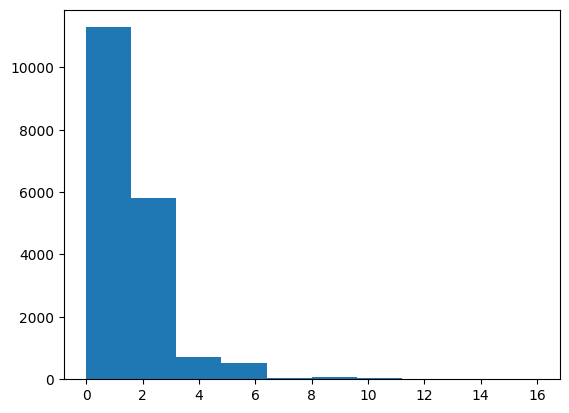

In [65]:
plt.hist(test['beds'])

In [66]:
#bathroomsに10371個中12個の欠損があったので平均で埋める
test_bathrooms_mean = test['bathrooms'].mean()
test['bathrooms'] = test['bathrooms'].fillna(test_bathrooms_mean)

#追加したbedsに欠損があった
test['beds'] = test['beds'].fillna(test_bathrooms_mean)

test_entire = test[test['room_type'] == 'Entire home/apt']
test_private = test[test['room_type'] == 'Private room']
test_share = test[test['room_type'] == 'Shared room']
dummy_test_entire = pd.get_dummies(test_entire[select_columns], drop_first=True)
dummy_test_private = pd.get_dummies(test_private[select_columns], drop_first=True)
dummy_test_share = pd.get_dummies(test_share[select_columns], drop_first=True)

In [67]:
# entire
pred_e_test = model_e.predict(dummy_test_entire)
# private
pred_p_test = model_p.predict(dummy_test_private)
# share
pred_s_test = model_s.predict(dummy_test_share)

test_re_merge = pd.concat([test_entire, test_private, test_share])
pred_test = np.concatenate([pred_e_test, pred_p_test, pred_s_test])

(array([1.900e+01, 7.831e+03, 1.788e+03, 3.020e+02, 3.110e+02, 4.000e+01,
        5.200e+01, 1.100e+01, 1.300e+01, 4.000e+00]),
 array([0.  , 0.75, 1.5 , 2.25, 3.  , 3.75, 4.5 , 5.25, 6.  , 6.75, 7.5 ]),
 <BarContainer object of 10 artists>)

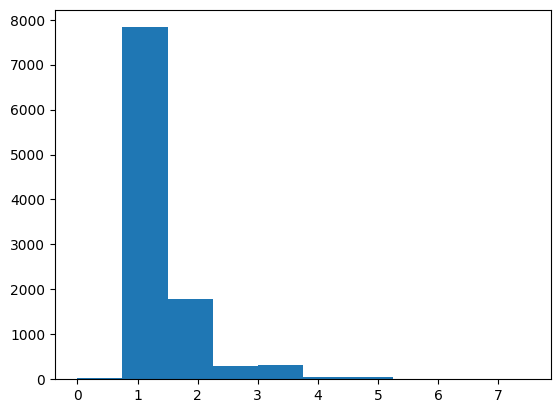

In [68]:
plt.hist(dummy_test_entire['bathrooms'])

In [69]:
test_re_merge['pred_y'] = pred_test

In [70]:
pred_test_sorted = test_re_merge.sort_values('id')
pred_test_sorted

,id,accommodates,amenities,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,cleaning_fee,...,property_type,review_scores_rating,room_type,thumbnail_url,zipcode,super_strict_60,real_bed,read_bed,thumbnail,pred_y
0,0,6,21,2.0,Real Bed,2.0,2.0,strict,Boston,1,...,House,90.000000,Entire home/apt,https://a0.muscache.com/im/pictures/7e4808b4-5...,02114,0,0,1.0,1,209.100000
1,1,3,20,1.0,Real Bed,1.0,1.0,moderate,LA,1,...,Guesthouse,100.000000,Entire home/apt,https://a0.muscache.com/im/pictures/5392fbd6-6...,90046,0,0,1.0,1,139.352869
2,2,2,10,1.0,Real Bed,0.0,1.0,flexible,NYC,0,...,Apartment,94.088167,Private room,https://a0.muscache.com/im/pictures/544d3b89-d...,11249.0,0,0,1.0,1,83.816793
3,3,4,17,1.0,Real Bed,1.0,2.0,strict,NYC,0,...,Apartment,94.088167,Entire home/apt,https://a0.muscache.com/im/pictures/26baf7ba-0...,11216,0,0,1.0,1,181.660000
4,4,3,14,1.5,Real Bed,1.0,2.0,strict,LA,1,...,Loft,92.000000,Entire home/apt,https://a0.muscache.com/im/pictures/86107545/9...,91604,0,0,1.0,1,124.370000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18523,18523,4,10,1.0,Real Bed,2.0,2.0,strict,NYC,1,...,Apartment,94.088167,Entire home/apt,https://a0.muscache.com/im/pictures/57338613/6...,11222,0,0,1.0,1,160.100000
18524,18524,2,15,1.0,Real Bed,2.0,1.0,flexible,Chicago,0,...,Apartment,90.000000,Entire home/apt,0,60657,0,0,1.0,0,144.020000
18525,18525,5,18,1.5,Real Bed,2.0,2.0,flexible,Chicago,1,...,House,94.088167,Entire home/apt,https://a0.muscache.com/im/pictures/361642af-e...,60618,0,0,1.0,1,391.540000
18526,18526,2,14,1.0,Real Bed,1.0,2.0,strict,NYC,1,...,Apartment,95.000000,Entire home/apt,https://a0.muscache.com/im/pictures/49c8e83f-d...,10029.0,0,0,1.0,1,142.789000


In [71]:
submission[1] = pred_test_sorted['pred_y']
submission

,1
0,
0,209.100000
1,139.352869
2,83.816793
3,181.660000
4,124.370000
...,...
18523,160.100000
18524,144.020000
18525,391.540000


In [72]:
submission.to_csv('submit.csv', header=None)